In [30]:
from 传统动量指标集 import *
from 传统波动率指标集 import *
from 国泰君安指标计算集 import *
from 世宽指标计算集 import *

import pandas as pd
import 计算函数包
from tqdm.contrib.concurrent import process_map
from multiprocessing import Pool, cpu_count
from functools import partial
import 回测函数包
import importlib
importlib.reload(回测函数包)
importlib.reload(计算函数包)
import 计算函数包 as cf
from 回测函数包 import *
import newbacktest

In [17]:
# 首先计算因子


if __name__ == "__main__":
    feature_compute_funcs = [
        high_low_5days, high_low_17days,

        volume_std_2days, volume_std_11days, volume_std_21days,

        returns_std_3days, returns_std_27days, returns_last_5days, returns_last_18day, returns_last_2days,

        weighted_avg_return_2, weighted_avg_return_42,

        returns_daliy_max_2days, returns_daliy_max_7days, returns_daliy_max_last_20days,

        sma_weight_con_23_37, sma_weight_con_3_62,

        flipping_weight_29_69, flipping_weight_4_67,

        gj_001, gj_002, gj_003, gj_004, gj_005, gj_006, gj_007, gj_008, gj_009, gj_010,
        gj_011, gj_012, gj_013, gj_014, gj_015, gj_016, gj_017, gj_018, gj_019, gj_020,
        gj_021, gj_022, gj_023, gj_024, gj_025, gj_026, gj_027, gj_028, gj_029, gj_031,
        gj_032, gj_033, gj_034, gj_035, gj_036, gj_037, gj_038, gj_039, gj_040, gj_041,
        gj_042, gj_043, gj_044, gj_045, gj_046, gj_047, gj_048, gj_049, gj_050, gj_051,
        gj_052, gj_053, gj_054, gj_056, gj_057, gj_058, gj_059, gj_060, gj_061, gj_062,
        gj_063, gj_064, gj_065, gj_066,

        wq_001, wq_002, wq_003, wq_004, wq_005, wq_006, wq_007, wq_008, wq_009, wq_010,
        wq_011, wq_012, wq_013, wq_014, wq_015, wq_016, wq_017, wq_018, wq_019, wq_020,
        wq_021, wq_022, wq_023, wq_024, wq_025, wq_026, wq_027, wq_028, wq_029, wq_030,
        wq_031, wq_032, wq_033, wq_034, wq_035, wq_036, wq_037, wq_038, wq_039, wq_040,
        wq_041, wq_042, wq_043, wq_044, wq_045, wq_046, wq_047, wq_049, wq_050, wq_051,
        wq_052, wq_053, wq_054, wq_055, wq_057, wq_065, wq_064, wq_060, wq_061, wq_066,
        wq_068, wq_070, wq_071, wq_072, wq_073, wq_074, wq_075, wq_077, wq_078, wq_081,
        wq_083, wq_085
    ]
    # 读取因子名
    feature_names = [func.__name__ for func in feature_compute_funcs]
    df = pd.read_csv("/Users/wangyanbo/24Spring/intern/MLBasedFuturesStrategy/Dataset/指标已计算/dataset.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df.loc[df['huanyue'] != 1]
    df = df.loc[df['date'].dt.dayofweek != 4]
    print("已删除所有周五和所有换月日")

    # TODO 修改初筛因子的方法
    ic = cf.information_coefficient(df, feature_list=feature_names)
    features = cf.factor_filter_double(df, ic, number_bar=0.1, top_n=15, ic_bar=0.07125)

    print(features)
    print("指标筛选已完成")

已删除所有周五和所有换月日
{'A': [], 'AG': ['gj_014', 'gj_019', 'returns_last_5days', 'gj_018', 'gj_066', 'gj_065', 'gj_026', 'gj_017', 'gj_046', 'gj_011', 'gj_063', 'gj_003', 'gj_022', 'gj_029', 'gj_047'], 'AL': ['gj_037', 'wq_005', 'wq_070', 'gj_012', 'wq_008'], 'AP': ['wq_025', 'wq_010', 'wq_018', 'wq_033', 'gj_054', 'wq_009', 'flipping_weight_4_67', 'gj_060', 'gj_010', 'flipping_weight_29_69', 'wq_028', 'weighted_avg_return_42', 'wq_035'], 'AU': ['gj_043', 'gj_022', 'returns_last_5days', 'gj_018', 'gj_019', 'gj_014'], 'BC': ['wq_025', 'wq_018', 'wq_010', 'wq_083', 'gj_054', 'wq_017', 'wq_054', 'wq_011', 'wq_009', 'gj_007', 'gj_002', 'wq_028', 'wq_033', 'wq_047', 'wq_066'], 'BU': ['gj_020', 'returns_last_5days', 'gj_018', 'gj_019', 'gj_017', 'gj_011', 'gj_014'], 'C': ['wq_044'], 'CF': ['returns_last_2days', 'returns_daliy_max_2days', 'gj_043', 'weighted_avg_return_2', 'gj_013', 'wq_041'], 'CJ': ['wq_065', 'weighted_avg_return_2', 'gj_046', 'returns_last_2days', 'gj_026', 'gj_027', 'wq_042', 'gj_

In [32]:
# 对于给定name的期货进行训练
diction_model = []
# TODO: 如何用上第一步初筛的结果
# selected_features = feature_names

name = 'AU'
results = []
# selected_features = features[name]
selected_features = feature_names
columns_to_extract = ['date'] + ['id'] + selected_features + ['returns']
df_subset = df[df['id'] == name][columns_to_extract]

# 删除缺失值
df_subset = df_subset.dropna(thresh=int(len(df_subset)*0.9), axis=1)
df_subset = df_subset.dropna()
df_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
df_subset.fillna(method='ffill', inplace=True)
df_subset['prediction'] = 0
df_subset['prediction'] = df_subset['prediction'].astype(float)

# 将数据前99%取出
threshold = int(0.99 * len(df_subset))
if threshold <= 287:
    # 如果某品种过往数据太少，这个品种将不参与运算
    print("当前品种交易数据太少")
else:
    df_subset['label'] = np.where(df_subset.index.isin(df_subset.index[:287]), -1, 1)
    diction_model.append(df_subset)

# results.append(cf.linear_regression_rolling(df_subset, length=287))


sum_length = sum(len(item) for item in diction_model)
print("元素总数是:", sum_length)

元素总数是: 1286


In [19]:
partial_function = partial(cf.linear_regression_rolling, length=287)
results = process_map(partial_function, diction_model, max_workers=cpu_count()-1)
prediction = pd.concat(results, ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
# partial_function = partial(cf.rolling_rnn, length = 287)
# partial_function_lasso = partial(cf.lasso_regression_rolling, length = 287)
# results_lasso = process_map(partial_function_lasso, diction_model)
# prediction_lasso = pd.concat(results_lasso, ignore_index = True)


# print(prediction)
print('滚动训练已结束,即将开始回测')

滚动训练已结束,即将开始回测


In [21]:
print(prediction['prediction'])
print(prediction['prediction'].mean())
print(prediction['prediction'].median())
print(prediction['prediction'].var())
print(sum(prediction['prediction']))
print(sum(abs(prediction['prediction'])))
print(len(prediction['prediction']))
print(sum(abs(prediction['prediction'])) / len(prediction['prediction']))

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1405    0.004992
1406    0.001688
1407    0.005182
1408    0.000904
1409    0.002795
Name: prediction, Length: 1410, dtype: float64
0.00020482796672859242
0.0
0.0003635063280191603
0.2888074330873151
3.8055764758923094
1410
0.002698990408434262


In [22]:

data_path = r"/Users/wangyanbo/24Spring/intern/MLBasedFuturesStrategy/Dataset/未连续化/标记了换月日的未连续化的日级数据.csv"
data = pd.read_csv(data_path)

data['date'] = pd.to_datetime(data['date'])
data = data.loc[data['id'] == name]
result = data.merge(prediction[['id', 'date', 'label', 'prediction']], on=['id', 'date'], how='left')
result['real_direction'] = result['open'] - result['close']
result['real_direction'] = np.where(result['real_direction'] > 0, 1, -1)
# result_lasso = data.merge(prediction_lasso[['id', 'date', 'label', 'prediction']], on=['id', 'date'], how='left')


In [31]:
bar = 0.002
# non_na_count = result['prediction'].notna().sum()
# print(non_na_count)
result = result.dropna(subset=['prediction'])
signals = cf.signals_day(result, bar)

# result_lasso = result.dropna(subset = ['prediction'])
# signals_lasso = cf.signals_day(result_lasso, bar)


In [10]:
# 使用信号生成函数生成交易记录，此处设置阈值为0.002
# signals = cf.signals_day(result, bar)
# 使用等市值函数将开仓手数进行等市值处理
# signals = equal_weight_l(signals, 80000, bar)
# 0409 80000, 0.002 800000
# signals_l = equal_weight_l(signals, 20000, bar)
signals = newbacktest.equal_weight(signals, 20000)

# signals_lasso_l = equal_weight_l(signals_lasso, 20000, bar)
# signals_lasso = equal_weight(signals_lasso, 20000)

print(signals)
signals['Open_Time'] = pd.to_datetime(signals['Open_Time']).dt.date
daily_transactions = signals.groupby('Open_Time')['Position'].sum()




# backtest(initial_capital, signals_l)
# backtest(initial_capital, signals_lasso)
# backtest(initial_capital, signals_lasso_l)

    Asset  Open_Time  Open_Price  Direction Close_Time  Close_Price  \
0      FG 2017-02-22      1368.0       -1.0 2017-02-22       1359.0   
1      FG 2017-02-23      1356.0       -1.0 2017-02-23       1340.0   
2      FG 2017-02-27      1344.0        1.0 2017-02-27       1351.0   
3      FG 2017-02-28      1353.0       -1.0 2017-02-28       1320.0   
4      FG 2017-03-01      1321.0        1.0 2017-03-01       1324.0   
..    ...        ...         ...        ...        ...          ...   
549    FG 2023-09-21      1722.0        1.0 2023-09-21       1683.0   
550    FG 2023-09-25      1749.0        1.0 2023-09-25       1691.0   
551    FG 2023-09-26      1700.0        1.0 2023-09-26       1680.0   
552    FG 2023-09-27      1690.0        1.0 2023-09-27       1693.0   
553    FG 2023-10-09      1711.0        1.0 2023-10-09       1724.0   

     Predicted_Return     Position  
0           -0.003002   52055136.0  
1           -0.003446   51256800.0  
2            0.002115   50953728.0  

最大回撤开始日期: 2021-07-22 00:00:00
最大回撤结束日期: 2021-09-09 00:00:00
交易次数: 554, 胜率: 51.81%, 日胜率: 51.81%, 盈亏比: 1.086, 日盈亏比: 1.086, 单笔平均盈亏: 27.058, 最大回撤: 0.035, 总收益率: 5.00%, 年化收益率: 0.74%, 夏普比率: -0.986, 卡玛比率: 0.213, 百次交易盈亏0.08043759750897972


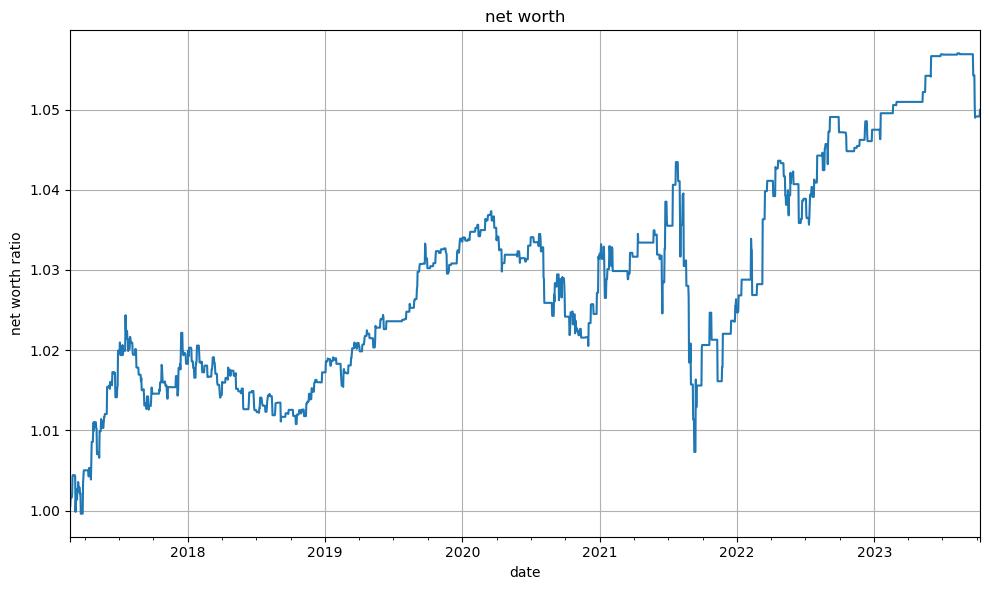

In [11]:
# 输出回测结果
%matplotlib inline

initial_capital = 300000
record_i_want, df_of_return, daily_return = newbacktest.backtest(initial_capital, signals)

In [12]:
from datetime import datetime
import os
timenow = datetime.now()
timestamp_str = timenow.strftime("%Y-%m-%d_%H-%M-%S") 
dir_name = f"records/{timestamp_str}"
os.makedirs(dir_name, exist_ok=True)  # Create directory if it doesn't exist
save_path = f"{dir_name}/signals.csv"  
signals.to_csv(save_path)

In [14]:
print("Daily Transaction \n", daily_transactions)
print("Max daily Transaction", daily_transactions.max())
print("Max Hands", abs(signals['Direction']).max())
print("Max Position Rate:", daily_transactions.max() / initial_capital)
print("Min Position Rate:", daily_transactions.min() / initial_capital)
print("Min daily transaction", daily_transactions.min())

Daily Transaction 
 Open_Time
2017-02-22     52055136.0
2017-02-23     51256800.0
2017-02-27     50953728.0
2017-02-28     50499372.0
2017-03-01     48935124.0
                 ...     
2023-09-21    140349888.0
2023-09-25    143054208.0
2023-09-26    137904000.0
2023-09-27    136930560.0
2023-10-09    141752928.0
Name: Position, Length: 554, dtype: float64
Max daily Transaction 549028860.0
Max Hands 1.0
Max Position Rate: 1830.0962
Min Position Rate: 100.264
Min daily transaction 30079200.0
